# Income Frequency

This notebook adjusts the income data to account for the frequency of reporting and creates a column that records the income as a monthly number.  It also looks at the distributions of the data to see what effect the adjustment has.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from drs_sentani import get_survey, strip_chart
survey = get_survey()

This is the distribution of frequencies used for income reporting in the data.  Overall the responses are fairly even between daily, monthly, and weekly frequencies.

In [2]:
survey['group_income_reg/electric_income_freq'].value_counts(dropna=False)

NaN            321
weekly         290
monthly        269
daily          264
not_regular     40
dtype: int64

Here I create a new temporary column 'income_monthly' and adjust for the frequency of reporting.  I then plot the quartiles and scatter plots.  The main thing I notice is that many points appear to be outliers on the high side once the adjustment is made.  If no frequency is given, I assume it is a monthly report.  We could also omit that data point.

In [3]:
# use the frequency label to multiply by the income and create new column
def return_monthly_income(row):
    frequency = {'weekly':4, 'monthly':1, 'daily':30.4, 'not_regular':1}
    # default to monthly
    if pd.isnull(row['group_income_reg/electric_income_freq']):
        freq = 'monthly'
    else:
        freq = row['group_income_reg/electric_income_freq']
    return row['group_income_reg/electric_income'] * frequency[freq]

survey['income_monthly'] = survey.apply(return_monthly_income, axis=1)

Below are the descriptions of the data before and after the adjustment.

In [4]:
# survey data as collected
survey['group_income_reg/electric_income'].describe()

count    1.109000e+03
mean     1.192605e+06
std      7.410150e+06
min      0.000000e+00
25%      1.000000e+05
50%      3.000000e+05
75%      1.000000e+06
max      2.400000e+08
Name: group_income_reg/electric_income, dtype: float64

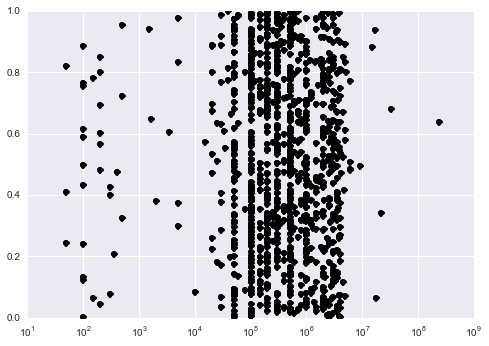

In [5]:
strip_chart(survey['group_income_reg/electric_income'])

In [6]:
# frequency-adjusted monthly income
survey['income_monthly'].describe()

count    1.109000e+03
mean     4.558420e+06
std      1.575439e+07
min      0.000000e+00
25%      4.000000e+05
50%      1.500000e+06
75%      3.040000e+06
max      2.400000e+08
Name: income_monthly, dtype: float64

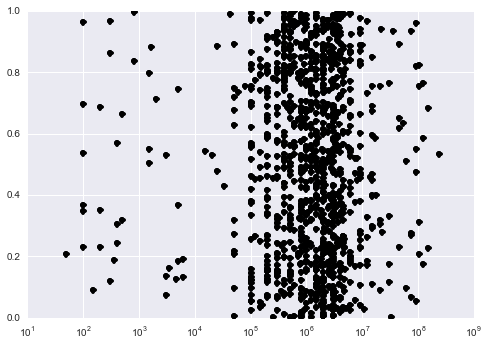

In [7]:
strip_chart(survey['income_monthly'])

Here I look at the frequency responses chosen by the enumerators.  It appears that the enumerators were fairly distributed in their choices so I don't see a clear bias that we can use to fill in missing frequencies.  The only enumerator with a clear pattern was 028f who did not enter a frequency at all.

/Users/dsoto/anaconda/envs/sentani/lib/python3.4/site-packages/pandas/core/generic.py:2390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


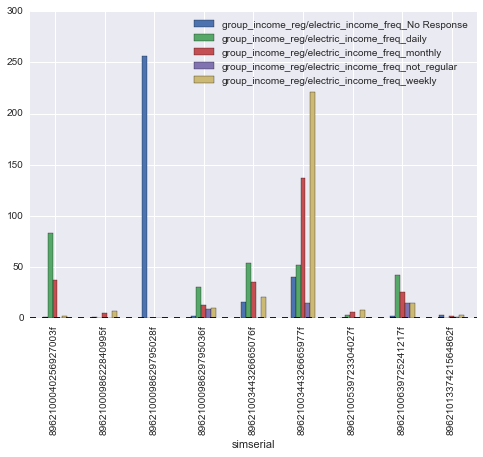

In [8]:
keys = ['simserial',
        'group_income_reg/electric_income_freq']
sdf = survey[keys]
# replace nulls with no response
sdf['group_income_reg/electric_income_freq'].fillna('No Response', inplace=True)
booled = pd.get_dummies(sdf, 
                        columns=['group_income_reg/electric_income_freq'])
booled.groupby('simserial').sum().plot(kind='bar')